In [42]:
import psycopg2
import numpy as np
import pandas as pd
import tslearn as tl
from getpass import getpass

In [43]:
################################
#### CHANGE TO YOUR DETAILS ####
user = 'lixan23'
db_ip = '10.158.72.112'
################################
pw = getpass('Enter the database password for {}: '.format(user))

Enter the database password for lixan23: ········


## Finding optimal decrease rate in visit

In [66]:
# get data function
def get_dataset( reference_day, tumbling_window_size = 38, output_window_size = 38 ):
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
      sql = """
      WITH 
      tumbling AS(
      SELECT customer_id,
             %(ref_date)s::date AS ref_day,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE AND purchased_at <= %(ref_date)s::DATE + %(ows)s THEN purchased_at::DATE ELSE null END) as output_feature,
             SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s AND purchased_at <= %(ref_date)s::DATE THEN value ELSE 0 END) as sale_f1,
             SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*2 AND purchased_at <= %(ref_date)s::DATE-%(ws)s THEN value ELSE 0 END ) as sale_f2,
             SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*3 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*2 THEN value ELSE 0 END ) as sale_f3,
             SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*4 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*3 THEN value ELSE 0 END ) as sale_f4,
             SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*5 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*4 THEN value ELSE 0 END ) as sale_f5,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s AND purchased_at <= %(ref_date)s::DATE THEN purchased_at::DATE ELSE null END ) as visit_f1,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*2 AND purchased_at <= %(ref_date)s::DATE-%(ws)s THEN purchased_at::DATE ELSE null END ) as visit_f2,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*3 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*2 THEN purchased_at::DATE ELSE null END ) as visit_f3,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*4 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*3 THEN purchased_at::DATE ELSE null END ) as visit_f4,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*5 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*4 THEN purchased_at::DATE ELSE null END ) as visit_f5
     FROM ml2.receipts_clean
     JOIN ml2.receipt_lines_clean
     USING (receipt_id)
     GROUP BY customer_id),
     
     rfm AS (
     SELECT customer_id,
             SUM(value) as total_spend,
             COUNT (DISTINCT purchased_at::DATE) as active_day,
             SUM(value)/COUNT (DISTINCT purchased_at) as basket_value,
             SUM (value)/ SUM (qty) as unit_cost,
             COUNT (DISTINCT product_code) as num_pro,
             COUNT(DISTINCT purchased_at::DATE)/((EXTRACT(day from (MAX(purchased_at)-MIN(purchased_at)))/%(ws)s)::INT+1) AS average_visit,
             SUM (value)/((EXTRACT(day from (MAX(purchased_at)-MIN(purchased_at)))/%(ws)s)::INT+1) AS average_spend
     FROM ml2.receipts_clean
     JOIN ml2.receipt_lines_clean
     USING (receipt_id)
     --below condition to make sure we do not include future data--
     WHERE purchased_at<=%(ref_date)s::date
     --and only consider the nearest 5 period--
     AND purchased_at>%(ref_date)s::DATE -%(ws)s*5
     GROUP BY customer_id
     --exclude people who not purchase in last period (strict churn)--
     HAVING MAX(purchased_at)>%(ref_date)s::DATE-%(ws)s),
             
     store AS (
     SELECT customer_id, store_code 
            FROM (SELECT customer_id, store_code, COUNT(*) AS ct
                    FROM ml2.receipts_clean
                    GROUP BY 1,2)x
            GROUP BY 1,2,ct
            HAVING ct=MAX(ct))
    
    SELECT * FROM tumbling JOIN store USING (customer_id) JOIN rfm USING (customer_id)
    
      """

      df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})

      return df.drop(columns = ['ref_day','output_feature','customer_id'], inplace = False), df.output_feature

In [67]:
# create ouput processing function with 
# make a deep copy version of y with each change in decrease level
from copy import deepcopy
def data_process (X,y,k):
    y_new=deepcopy(y)
    for i in range(len(y_new)):
        # X.iloc[i,-2]: data in column 'average_visit'
        if y_new[i]<=X.iloc[i,-2]*k:
            y_new[i]=1
        else:
            y_new[i]=0
    return X, y_new

In [68]:
# calculating churn rate & model performance with each change in decrease level
# using 5 folds of temporal hold outs
# storing churn rate in curve, AUC in acc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rf=RandomForestClassifier(random_state=42, min_samples_leaf=30)
import datetime  
from datetime import timedelta
ref_date= datetime.date(2020,10,17)
index=[i/100 for i in range(0,100)]
fold=5
acc={}
curve={}
for k in range(fold):
    ref_test=str(ref_date-timedelta(days=38*k))
    ref_train=str(ref_date-timedelta(days=38*(k+1)))
    X_test, y_test=get_dataset(ref_test)
    X_train, y_train=get_dataset(ref_train)
    acc[k]=[]
    curve[k]=[]
    for j in index:
        X_test_new,y_test_new=data_process (X_test,y_test,j)
        X_test_min=X_test_new
        X_train_new, y_train_new=data_process (X_train,y_train,j)
        curve[k].append(len(y_test_new[y_test_new==1])/len(y_test_new))
        rf.fit(X_train_new,y_train_new)
        y_pred=rf.predict_proba(X_test_new)[:,1]
        acc[k].append(roc_auc_score(y_test_new,y_pred))

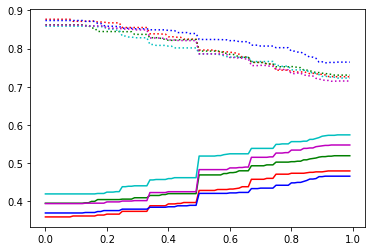

In [69]:
# plotting the results
import matplotlib.pyplot as plt
plt.plot(index, curve[0], 'r-')
plt.plot(index, curve[1], 'g-')
plt.plot(index, curve[2], 'b')
plt.plot(index, curve[3], 'c-')
plt.plot(index, curve[4], 'm-')
plt.plot(index, acc[0], 'r:')
plt.plot(index, acc[1], 'g:')
plt.plot(index, acc[2], 'b:')
plt.plot(index, acc[3], 'c:')
plt.plot(index, acc[4], 'm:')

In [70]:
#average churn rate at 0.49 threshold
(curve[0][49] + curve[1][49] + curve[2][49] + curve[3][49] + curve[4][49])/5

0.418446506552072

In [71]:
#average churn rate at 0 threshold - meaning using global churn definition
(curve[0][0] + curve[1][0] + curve[2][0] + curve[3][0] + curve[4][0])/5

0.387145263962306

In [72]:
#average AUC at 0.49 threshold
(acc[0][49] + acc[1][49] + acc[2][49] + acc[3][49] + acc[4][49])/5

0.8218751361028025

## Finding optimal decrease rate in sales

In [73]:
# revise get data function - decode sale by dividing to 7.235 (Q1 of average spending)
def get_dataset( reference_day, tumbling_window_size = 38, output_window_size = 38 ):
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
      sql = """
      WITH 
      tumbling AS(
      SELECT customer_id,
             %(ref_date)s::date AS ref_day,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE AND purchased_at <= %(ref_date)s::DATE + %(ows)s THEN purchased_at::DATE ELSE null END) as output_feature,
             (SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s AND purchased_at <= %(ref_date)s::DATE THEN value ELSE 0 END)/7.245)::INT as sale_f1,
             (SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*2 AND purchased_at <= %(ref_date)s::DATE-%(ws)s THEN value ELSE 0 END)/7.245)::INT as sale_f2,
             (SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*3 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*2 THEN value ELSE 0 END)/7.245)::INT as sale_f3,
             (SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*4 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*3 THEN value ELSE 0 END)/7.245)::INT as sale_f4,
             (SUM(CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*5 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*4 THEN value ELSE 0 END)/7.245)::INT as sale_f5,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s AND purchased_at <= %(ref_date)s::DATE THEN purchased_at::DATE ELSE null END ) as visit_f1,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*2 AND purchased_at <= %(ref_date)s::DATE-%(ws)s THEN purchased_at::DATE ELSE null END ) as visit_f2,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*3 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*2 THEN purchased_at::DATE ELSE null END ) as visit_f3,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*4 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*3 THEN purchased_at::DATE ELSE null END ) as visit_f4,
             COUNT (DISTINCT CASE WHEN purchased_at > %(ref_date)s::DATE -%(ws)s*5 AND purchased_at <= %(ref_date)s::DATE-%(ws)s*4 THEN purchased_at::DATE ELSE null END ) as visit_f5
     FROM ml2.receipts_clean
     JOIN ml2.receipt_lines_clean
     USING (receipt_id)
     GROUP BY customer_id),
     
     rfm AS (
     SELECT customer_id,
             SUM(value) as total_spend,
             COUNT (DISTINCT purchased_at::DATE) as active_day,
             SUM(value)/COUNT (DISTINCT purchased_at) as basket_value,
             SUM (value)/ SUM (qty) as unit_cost,
             COUNT (DISTINCT product_code) as num_pro,
             COUNT(DISTINCT purchased_at::DATE)/((EXTRACT(day from (MAX(purchased_at)-MIN(purchased_at)))/%(ws)s)::INT+1) AS average_visit,
             ((SUM (value)/((EXTRACT(day from (MAX(purchased_at)-MIN(purchased_at)))/%(ws)s)::INT+1))/7.245)::INT AS average_spend
     FROM ml2.receipts_clean
     JOIN ml2.receipt_lines_clean
     USING (receipt_id)
     --below condition to make sure we do not include future data--
     WHERE purchased_at<=%(ref_date)s::date
     --and only consider the nearest 5 period--
     AND purchased_at>%(ref_date)s::DATE -%(ws)s*5
     GROUP BY customer_id
     --exclude people who not purchase in last period (strict churn)--
     HAVING MAX(purchased_at)>%(ref_date)s::DATE-%(ws)s),
             
     store AS (
     SELECT customer_id, store_code 
            FROM (SELECT customer_id, store_code, COUNT(*) AS ct
                    FROM ml2.receipts_clean
                    GROUP BY 1,2)x
            GROUP BY 1,2,ct
            HAVING ct=MAX(ct))
    
    SELECT * FROM tumbling JOIN store USING (customer_id) JOIN rfm USING (customer_id)
    
      """

      df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})

      return df.drop(columns = ['ref_day','output_feature','customer_id'], inplace = False), df.output_feature

In [74]:
# create ouput processing function with 
# make a deep copy version of y with each change in decrease level
from copy import deepcopy
def data_process (X,y,k):
    y_new=deepcopy(y)
    for i in range(len(y_new)):
        # X.iloc[i,-2]: data in column 'average_spend'
        if y_new[i]<=X.iloc[i,-1]*k:
            y_new[i]=1
        else:
            y_new[i]=0
    return X, y_new

In [75]:
# calculating churn rate & model performance with each change in decrease level
# using 5 folds of temporal hold outs
# storing churn rate in curve, AUC in acc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rf=RandomForestClassifier(random_state=42, min_samples_leaf=30)
import datetime  
from datetime import timedelta
ref_date= datetime.date(2020,10,17)
index=[i/100 for i in range(0,100)]
fold=5
acc={}
curve={}
for k in range(fold):
    ref_test=str(ref_date-timedelta(days=38*k))
    ref_train=str(ref_date-timedelta(days=38*(k+1)))
    X_test, y_test=get_dataset(ref_test)
    X_train, y_train=get_dataset(ref_train)
    acc[k]=[]
    curve[k]=[]
    for j in index:
        X_test_new,y_test_new=data_process (X_test,y_test,j)
        X_test_min=X_test_new
        X_train_new, y_train_new=data_process (X_train,y_train,j)
        curve[k].append(len(y_test_new[y_test_new==1])/len(y_test_new))
        rf.fit(X_train_new,y_train_new)
        y_pred=rf.predict_proba(X_test_new)[:,1]
        acc[k].append(roc_auc_score(y_test_new,y_pred))

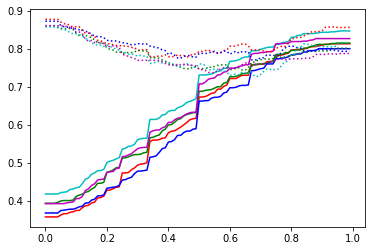

In [76]:
# plotting the results
import matplotlib.pyplot as plt
plt.plot(index, curve[0], 'r-')
plt.plot(index, curve[1], 'g-')
plt.plot(index, curve[2], 'b')
plt.plot(index, curve[3], 'c-')
plt.plot(index, curve[4], 'm-')
plt.plot(index, acc[0], 'r:')
plt.plot(index, acc[1], 'g:')
plt.plot(index, acc[2], 'b:')
plt.plot(index, acc[3], 'c:')
plt.plot(index, acc[4], 'm:')

In [77]:
#average churn rate at 0.49 threshold - significantly higher with visit
(curve[0][49] + curve[1][49] + curve[2][49] + curve[3][49] + curve[4][49])/5

0.6289955432458286

In [78]:
#average AUC at 0.49 threshold - lower than visit even after coding due to widely spread value
(acc[0][49] + acc[1][49] + acc[2][49] + acc[3][49] + acc[4][49])/5

0.7652166671711922